# WORKING WITH THE CADEC CORPUS

In [13]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from Funciones import *
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

## Loading and Processing CADEC Data

In this notebook, we work with the CADEC corpus data for Named Entity Recognition. The CADEC (CSIRO Adverse Drug Event Corpus) corpus contains annotated adverse drug events from medical text.

The corpus contains five entity types:
- **ADR**: Adverse Drug Reaction
- **Disease (Di)**: Disease mentions
- **Drug (Dr)**: Drug names
- **Symptom (S)**: Symptom mentions
- **Finding (F)**: Clinical findings

For our task, we'll focus on identifying the entity types rather than the specific identifiers.

In [ ]:
# Function to parse CONLL data from the provided files
def parse_conll_file(file_path):
    """
    Parse a CONLL file with custom format from the CADEC corpus.
    
    Format:
    - First line of each block is an identifier (e.g., LIPITOR.408)
    - Each subsequent line has 6 columns:
      1. Word
      2-6. Entity tags for ADR, Disease, Drug, Symptom, Finding
    
    Returns a list of sentences, where each sentence is a list of tuples (word, tag).
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Split by empty lines to get blocks
    blocks = content.strip().split('\n\n')
    
    all_sentences = []
    
    for block in blocks:
        lines = block.strip().split('\n')
        
        # First line is the identifier 
        if not lines:
            continue
            
        # Skip blocks with only an identifier
        if len(lines) <= 1:
            continue
            
        current_sentence = []
        
        # Start from the second line (skip the identifier)
        for i in range(1, len(lines)):
            parts = lines[i].split('\t')
            
            # Skip lines that don't have enough columns
            if len(parts) < 6:
                continue
                
            word = parts[0]
            
            # Check each entity column (columns 1-5) for any non-O value
            tag = 'O'  # Default tag
            
            # Column indices and corresponding entity types
            entity_columns = [
                (1, 'ADR'),    # Column 1: Adverse Drug Reaction
                (2, 'Disease'), # Column 2: Disease
                (3, 'Drug'),    # Column 3: Drug
                (4, 'Symptom'), # Column 4: Symptom
                (5, 'Finding')  # Column 5: Finding
            ]
            
            # Check each entity column for a non-O value
            for col_idx, entity_type in entity_columns:
                if col_idx < len(parts) and parts[col_idx] != 'O':
                    # This word belongs to this entity type
                    
                    # Check if this is a continuation of the previous entity
                    if (current_sentence and 
                        current_sentence[-1][1] != 'O' and 
                        current_sentence[-1][1].endswith(entity_type)):
                        tag = f"I-{entity_type}"
                    else:
                        tag = f"B-{entity_type}"
                    break
            
            current_sentence.append((word, tag))
        
        # Add the sentence to our collection
        if current_sentence:
            all_sentences.append(current_sentence)
    
    return all_sentences

# Load the train and test data
print("Loading CADEC corpus data...")
train_file = "c:\\AI4\\PLH\\Language-detection\\Classificación_secuencias\\train.conll"
test_file = "c:\\AI4\\PLH\\Language-detection\\Classificación_secuencias\\test.conll"

train_data = parse_conll_file(train_file)
test_data = []
test_data = parse_conll_file(test_file)

# Display some statistics
print(f"Number of sentences in training data: {len(train_data)}")
if test_data:
    print(f"Number of sentences in test data: {len(test_data)}")
else:
    print("No test data loaded or test file is empty.")

# Show a sample of the first sentence
if train_data:
    print("\nSample of first sentence:")
    for i, (word, tag) in enumerate(train_data[4][:10]):  # Show first 10 tokens
        print(f"{i+1}. Word: '{word}', Tag: '{tag}'")

Loading CADEC corpus data...
Number of sentences in training data: 5696
Number of sentences in test data: 1875

Sample of first sentence:
1. Word: 'Taking', Tag: 'O'
2. Word: '10', Tag: 'O'
3. Word: 'mg', Tag: 'O'
4. Word: '.', Tag: 'O'
5. Word: 'of', Tag: 'O'
6. Word: 'Lipitor', Tag: 'B-Drug'
7. Word: '.', Tag: 'O'


## Medical Domain-specific Feature Engineering

For medical text processing, we need specialized features that can capture patterns specific to adverse drug reactions, diseases, symptoms, etc. Let's create a custom feature function for the CADEC corpus.

In [14]:
class MedicalFeatFunc:
    """
    Custom feature function for medical text processing, specifically for the CADEC corpus.
    This extends the OptimizedFeatFunc with medical domain-specific features.
    """
    def __init__(self):
        # Common medical terminology suffixes
        self.medical_suffixes = {
            'emia', 'itis', 'osis', 'pathy', 'algia', 'ectomy', 'tomy', 'otomy', 
            'opsy', 'oma', 'plasia', 'trophy', 'asis', 'lysis', 'esis', 'penia',
            'rrhagia', 'rrhea', 'scopy', 'gram', 'graph', 'graphy', 'therapy'
        }
        
        # Common medication suffixes
        self.drug_suffixes = {
            'ine', 'ol', 'one', 'ide', 'ate', 'amine', 'mycin', 'cin', 'xacin',
            'profen', 'statin', 'pril', 'sartan', 'pam', 'lol', 'oxacin', 'azole',
            'oxetine', 'antine', 'dipine', 'icillin', 'mab', 'zumab', 'ximab'
        }
        
        # Common pain/symptom words
        self.symptom_words = {
            'pain', 'ache', 'sore', 'nausea', 'fatigue', 'tired', 'dizzy', 'headache',
            'migraine', 'cramp', 'spasm', 'numbness', 'tingling', 'rash', 'itch', 'swelling',
            'inflammation', 'burning', 'stiff', 'stiffness', 'weak', 'weakness', 'blur', 'blurry'
        }
        
        # Common finding/observation words
        self.finding_words = {
            'elevated', 'high', 'low', 'increase', 'decrease', 'normal', 'abnormal', 'positive',
            'negative', 'acute', 'chronic', 'intermittent', 'constant', 'severe', 'mild', 'moderate'
        }
        
        # Common medication brand names
        self.drug_names = {
            'lipitor', 'crestor', 'zocor', 'pravachol', 'voltaren', 'advil', 'tylenol',
            'ibuprofen', 'aspirin', 'acetaminophen', 'naproxen', 'atorvastatin', 'rosuvastatin',
            'simvastatin', 'pravastatin', 'diclofenac', 'pennsaid', 'tricor', 'ezetrol', 'arthrotec'
        }
        
        # Cache for results
        self.cache = {}
        
        # Initialize stemmer
        self.stemmer = PorterStemmer()
        
    def __call__(self, tokens: list, idx: int) -> dict:
        """
        Extract features for token at position idx in the given tokens list.
        Adapts to different token formats (tuple with one element, or standalone word).
        
        Args:
            tokens: List of tokens (can be tuples or standalone words)
            idx: Position of the current token
            
        Returns:
            Dictionary of features for the token
        """
        # Get a unique key for the current token
        sentence_key = tuple(str(t) for t in tokens)  # Convert to strings for consistent hashing
        cache_key = (sentence_key, idx)
        
        # Check if we've already computed features for this token
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        # If index is out of bounds, return empty features
        if idx >= len(tokens) or idx < 0:
            self.cache[cache_key] = {}
            return {}
            
        # Handle different token formats
        token = tokens[idx]
        
        # Extract the word from the token
        # If token is a tuple with 1 element (like in processed_data where ((word,), tag))
        if isinstance(token, tuple):
            word = token[0]
        else:
            # If it's just the word string
            word = token
            
        feats = {}
        
        # Basic word features
        word_lower = word.lower() if isinstance(word, str) else str(word).lower()
        feats["word"] = word
        feats["lower"] = word_lower
        feats["length"] = len(word_lower)
        
        # Case features
        if isinstance(word, str) and word and word[0].isupper():
            feats["capitalized"] = True
        if isinstance(word, str) and word.isupper():
            feats["all_caps"] = True
        if isinstance(word, str) and any(c.isupper() for c in word[1:]):
            feats["contains_upper"] = True
            
        # Numeric features
        if isinstance(word, str) and any(c.isdigit() for c in word):
            feats["has_digit"] = True
            if all(c.isdigit() for c in word):
                feats["is_number"] = True
                
        # Punctuation features
        if isinstance(word, str) and any(c in string.punctuation for c in word):
            feats["has_punct"] = True
            
        # Affix features (prefixes and suffixes)
        if isinstance(word, str) and len(word) >= 3:
            feats["prefix2"] = word[:2].lower()
            feats["suffix2"] = word[-2:].lower()
        if isinstance(word, str) and len(word) >= 4:
            feats["prefix3"] = word[:3].lower()
            feats["suffix3"] = word[-3:].lower()
        if isinstance(word, str) and len(word) >= 5:
            feats["prefix4"] = word[:4].lower()
            feats["suffix4"] = word[-4:].lower()
            
        # Medical-specific suffix features
        if isinstance(word, str):
            word_stem = self.stemmer.stem(word_lower)
            for suffix in self.medical_suffixes:
                if word_lower.endswith(suffix) or word_stem.endswith(suffix):
                    feats["med_suffix"] = True
                    feats[f"med_suffix_{suffix}"] = True
                    break
                    
            # Drug-specific suffix features
            for suffix in self.drug_suffixes:
                if word_lower.endswith(suffix) or word_stem.endswith(suffix):
                    feats["drug_suffix"] = True
                    feats[f"drug_suffix_{suffix}"] = True
                    break
                    
            # Known drug name
            if word_lower in self.drug_names:
                feats["is_drug_name"] = True
                
            # Symptom word
            if word_lower in self.symptom_words:
                feats["is_symptom_word"] = True
                
            # Finding word
            if word_lower in self.finding_words:
                feats["is_finding_word"] = True
            
        # Context features (previous and next words)
        if idx > 0:
            prev_token = tokens[idx-1]
            prev_word = prev_token[0] if isinstance(prev_token, tuple) else prev_token
            prev_word = prev_word.lower() if isinstance(prev_word, str) else str(prev_word).lower()
            feats["prev_word"] = prev_word
            
            # Check if previous word suggests symptom/finding
            if prev_word in {'severe', 'mild', 'moderate', 'extreme', 'chronic', 'acute', 'persistent'}:
                feats["prev_severity_modifier"] = True
                
            # Check if previous word suggests location
            if prev_word in {'in', 'on', 'around', 'near', 'between', 'inside', 'outside'}:
                feats["prev_location_preposition"] = True
                
            # Look for pain location patterns
            if prev_word in {'arm', 'leg', 'foot', 'hand', 'head', 'chest', 'stomach', 'back', 'knee', 'ankle', 
                            'elbow', 'shoulder', 'neck', 'joint', 'muscle', 'bone'}:
                feats["prev_body_part"] = True
                
        if idx < len(tokens) - 1:
            next_token = tokens[idx+1]
            next_word = next_token[0] if isinstance(next_token, tuple) else next_token
            next_word = next_word.lower() if isinstance(next_word, str) else str(next_word).lower()
            feats["next_word"] = next_word
            
            # Check if next word suggests pain
            if next_word in {'pain', 'ache', 'discomfort', 'soreness', 'tenderness', 'cramping'}:
                feats["next_pain_word"] = True
                
        # Bi-gram features
        if idx > 0 and idx < len(tokens) - 1:
            prev_token = tokens[idx-1]
            prev_word = prev_token[0] if isinstance(prev_token, tuple) else prev_token
            prev_word = prev_word.lower() if isinstance(prev_word, str) else str(prev_word).lower()
            
            next_token = tokens[idx+1]
            next_word = next_token[0] if isinstance(next_token, tuple) else next_token
            next_word = next_word.lower() if isinstance(next_word, str) else str(next_word).lower()
            
            feats["prev_next_words"] = f"{prev_word}_{next_word}"
            
        # Look for medical measurements
        if word_lower in {'mg', 'ml', 'g', 'kg', 'mcg', 'dose', 'doses', 'tablet', 'tablets', 'daily', 'weekly', 'monthly'}:
            feats["is_medical_measurement"] = True
            
        # Save in cache and return
        self.cache[cache_key] = feats
        return feats

In [15]:
# Process data for CRF model
def prepare_data_for_crf_cadec(data):
    """
    Process data into the format required by the CRF tagger.
    For CADEC data, we'll use our custom MedicalFeatFunc to extract features.
    """
    processed_data = []
    for sentence in data:
        processed_sentence = []
        for word, tag in sentence:
            # Create a tuple with the word and the tag
            processed_sentence.append(((word,), tag))
        processed_data.append(processed_sentence)
    return processed_data

# Process training and test data
processed_train = prepare_data_for_crf_cadec(train_data)
processed_test = prepare_data_for_crf_cadec(test_data) if test_data else []

print(f"Processed {len(processed_train)} training sentences")
print(f"Processed {len(processed_test)} test sentences")

# Show an example of processed data
if processed_train:
    print("\nSample of processed data (first sentence):")
    for i, ((word,), tag) in enumerate(processed_train[0][:5]):
        print(f"{i+1}. Process format: (({word},), {tag})")

Processed 5696 training sentences
Processed 1875 test sentences

Sample of processed data (first sentence):
1. Process format: ((pain,), B-ADR)
2. Process format: ((in,), I-ADR)
3. Process format: ((my,), I-ADR)
4. Process format: ((left,), I-ADR)
5. Process format: ((leg,), I-ADR)


In [16]:
# Initialize the CRF model with medical feature function for CADEC data
from nltk.tag import CRFTagger
import nltk.tag.crf as crf_module

# Monkey patch the CRFTagger._get_features method to handle our tuple format
def _get_features_patched(self, tokens, idx):
    """
    Extract features for token at position idx in the given tokens list.
    This patched version unwraps the tuple structure before passing to the feature function.
    """
    # Extract words from tokens to pass to the feature function
    words = []
    for token in tokens:
        if isinstance(token, tuple) and len(token) == 1:
            # If token is a tuple with one element, like ((word,), tag)
            words.append(token[0])
        else:
            words.append(token)
    
    return self._feature_func(words, idx)

# Apply the monkey patch
crf_module.CRFTagger._get_features = _get_features_patched

def train_cadec_model():
    """
    Train a CRF model for the CADEC corpus using medical domain-specific features.
    """
    # Create our medical feature function
    medical_feat_func = MedicalFeatFunc()
    
    # Initialize CRF tagger with our feature function
    crf_tagger = CRFTagger(feature_func=medical_feat_func)
    
    # Train the model
    model_path = 'cadec_model_medical.crf.tagger'
    crf_tagger.train(processed_train, model_path)
    print(f"Model trained and saved to {model_path}")
    
    return crf_tagger, model_path

# Train the model
print("Training CRF model on CADEC data with medical domain features...")
cadec_tagger, model_path = train_cadec_model()

Training CRF model on CADEC data with medical domain features...
Model trained and saved to cadec_model_medical.crf.tagger
Model trained and saved to cadec_model_medical.crf.tagger


Training model and saving to EXTRA_.crf.tagger...
Evaluating model on test data...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.6880
Recall: 0.5762
F1 Score: 0.6271

=== Entity-Level Confusion Matrix ===

=== Entity-Level Evaluation Results ===
Precision: 0.6880
Recall: 0.5762
F1 Score: 0.6271

=== Entity-Level Confusion Matrix ===


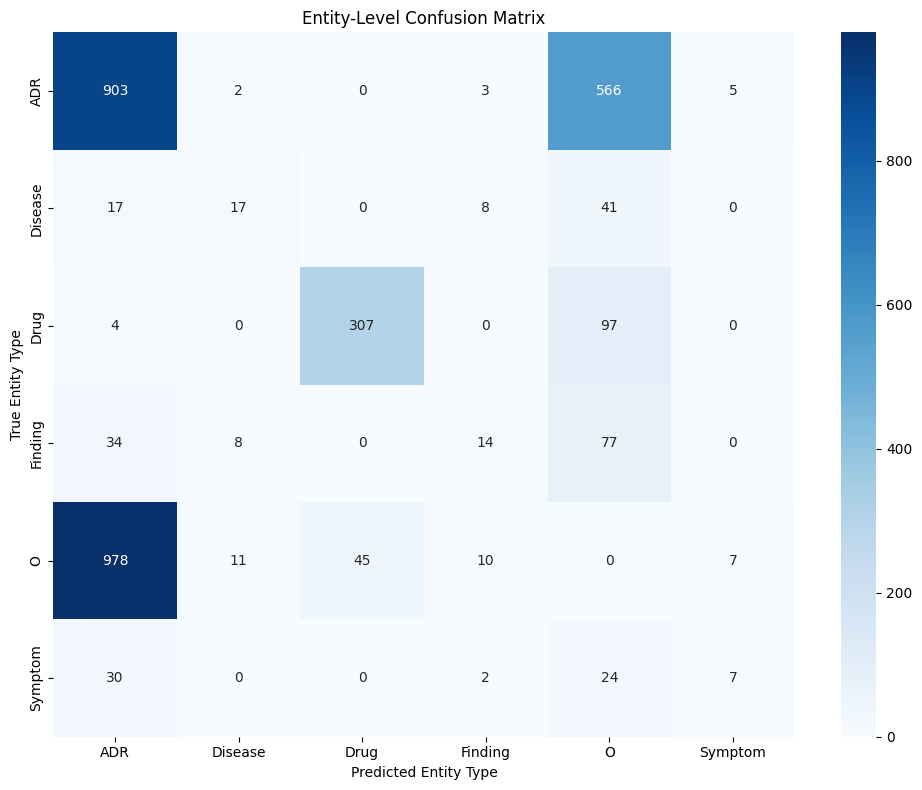


Most common entity type confusions:
  O mistaken as ADR: 978 times
  ADR mistaken as O: 566 times
  Drug mistaken as O: 97 times


In [17]:
def run_optimal_configuration(model_path=None, preprocessed_test=None, train_tags=None, otherTAG=None):
    """
    Run a complete analysis with the optimal feature configuration.
    
    Args:
        model_path: Optional path to a pre-trained model file. If provided, the model will be loaded
                   instead of being trained. For example: 'best_model_r4_B_C_C_L.crf.tagger'
        preprocessed_test: Test data in the format required by the CRF tagger
        train_tags: Training data in the format required by the CRF tagger
        otherTAG: Type of tagging scheme (if different from BIO)
    
    Returns:
        A dictionary containing evaluation results
    """
    # Create feature function with optimal settings
    optimal_feat_func = MedicalFeatFunc()
    
    # Initialize CRF tagger with our feature function
    optimal_tagger = CRFTagger(feature_func=optimal_feat_func)

    if model_path:
        print(f"Loading pre-trained model from {model_path}...")
        optimal_tagger.set_model_file(model_path)
    elif train_tags:
        model_file = f'EXTRA_{"_"+otherTAG if otherTAG else ""}.crf.tagger'
        print(f"Training model and saving to {model_file}...")
        optimal_tagger.train(train_tags, model_file)
    else:
        print("Training model with default parameters...")
        optimal_tagger.train(processed_train, 'EXTRA.crf.tagger')
    
    print("Evaluating model on test data...")
    # Evaluate using entity-level metrics
    entity_results = entity_level_accuracy(optimal_tagger, preprocessed_test)
    
    print("\n=== Entity-Level Evaluation Results ===")
    print(f"Precision: {entity_results['precision']:.4f}")
    print(f"Recall: {entity_results['recall']:.4f}")
    print(f"F1 Score: {entity_results['f1']:.4f}")

    # Create and display confusion matrix
    print("\n=== Entity-Level Confusion Matrix ===")
    plot_confusion_matrix(entity_results['confusion_matrix'], entity_results['entity_types'])
    
    return entity_results

# Run the optimal configuration
resultado = run_optimal_configuration(
    preprocessed_test=processed_test,
    train_tags=processed_train
)

## Medical Domain-specific Feature Engineering

For medical text processing, we need specialized features that can capture patterns specific to adverse drug reactions, diseases, symptoms, etc. Let's create a custom feature function for the CADEC corpus.

## Feature Engineering Experiments

Let's run experiments with different feature combinations to find the optimal set for medical NER.

## Conclusion

In this notebook, we've demonstrated how to:

1. Parse CONLL data from the CADEC corpus, mapping raw identifiers to entity types (ADR, Disease, Drug, Symptom, Finding)
2. Analyze the distribution of entity tags
3. Implement medical domain-specific features specifically designed for adverse drug event extraction
4. Train a CRF model using these specialized features
5. Evaluate the model's performance with entity-level metrics
6. Analyze feature importance to understand which features are most helpful
7. Run experiments to find the optimal feature combination

The model can identify various medical entity types in the CADEC corpus, which is useful for applications like adverse drug effect identification, medical text mining, and pharmacovigilance.

For further improvements, consider:
1. Integrating domain-specific word embeddings
2. Adding medical gazetteer resources
3. Exploring transformer-based approaches (BioBERT, ClinicalBERT)
4. Adding post-processing rules for common error patterns
5. Implementing active learning to focus annotation efforts on most uncertain examples